In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import Demand
import Solar
import Price
import Date
import Forecast

In [2]:
'''
NEW smart with average across 2014 as solar
'''

'\nNEW smart with average across 2014 as solar\n'

In [3]:
def predictedcharge(bigdata, daywanted):
    
    prediction = pd.read_csv('Data/solarprediction.csv')

    predicted_charge = prediction['0'][daywanted-1]

#     daydemand = []
#     for n in range(24):
#         if bigdata['Total Supply (kWh)'][n] > 0:
#             daydemand.append(bigdata['Total Demand (kWh)'][n])

#     predicted_charge = predicted_charge-np.sum(daydemand)
    
    return predicted_charge

In [4]:
def chargeneeded(bigdata):

    eff = 0.9
    chargeneeded = 0
    median = np.median(bigdata['Grid Buy Price'])
    batterycharge = 0
    

    for n in range(0,24):
            
        if bigdata['Grid Buy Price'][n] >= median*1.5:
            chargeneeded = chargeneeded + bigdata['Net Demand'][n]/(eff)


    return chargeneeded


In [5]:
## method to run the SMART system ##
## if its predicted

def run_SMART(bigdata, daywanted, starting_soc):
    
    batteryoutput = np.zeros(24)
    soc = np.ones(24)*0
    capacity = 1120
    power = 415
    eff = 0.9
    
    median = np.median(bigdata['Grid Buy Price'])
    required_battery_charge = chargeneeded(bigdata)
    predicted_battery_charge = predictedcharge(bigdata, daywanted)
    
    print(required_battery_charge, predicted_battery_charge)
    
    for n in range(0,24):
        
        if n == 0:
            soc_temp = starting_soc[daywanted-1]
        else:
            soc_temp = soc[n-1]

        ## the smart design ##
        ## the smart design ##
        ## the smart design ##

        
        if required_battery_charge > predicted_battery_charge: 
            if n == 5:
                batteryoutput[n] = max(-power, -(1/eff)*(required_battery_charge - predicted_battery_charge))
                soc[n] = soc_temp - batteryoutput[n]*eff
                continue
                
        if n == 0:
            use = True
        if n == 14:
            use = False
        if bigdata['Grid Buy Price'][n] >= median*1.5:
            use = True
            

        ## the smart design ##
        ## the smart design ##
        ## the smart design ##

        if bigdata['Net Demand'][n] > 0:   #using the battery
            batteryoutput[n] = min(bigdata['Net Demand'][n], soc_temp*eff, power)
            soc[n] = soc_temp - batteryoutput[n]*(1/eff)
            if use == False:
                soc[n] = soc[n-1]
                batteryoutput[n] = 0

        elif bigdata['Net Demand'][n] < 0:     # charge the battery
            batteryoutput[n] = max(bigdata['Net Demand'][n], -(1/eff)*(capacity - soc_temp), -power)
            soc[n] = soc_temp - batteryoutput[n]*(eff)

        elif bigdata['Net Demand'][n] == 0:      # do nothing
            soc[n] = soc_temp

        
    ## adds the battery output to total demand and adds to bigdata ##

    bigdata['Net Demand - SMART'] = bigdata['Net Demand']-batteryoutput
    bigdata['Running Cost - SMART'] = bigdata['Net Demand - SMART']*bigdata['Grid Buy Price']
    bigdata['Running Cost - SMART'] = bigdata['Running Cost - SMART'].clip(lower=0)
    bigdata['Running Profit - SMART'] = -bigdata['Net Demand - SMART']*bigdata['Grid Sell Price']
    bigdata['Running Profit - SMART'] = bigdata['Running Profit - SMART'].clip(lower=0)
    bigdata['soc - SMART'] = soc
    bigdata['battery output - SMART'] = batteryoutput
    
    ## adds the end day soc into the global vector to use for the next day ##
    starting_soc[daywanted] = soc[23]
    ## returns the new bigdata ##
    
    return bigdata


In [6]:
## initialises the daily cost vectors ##
SMART_cost = np.zeros(365)
SMART_profit = np.zeros(365)
_import_ = np.zeros(24*365)
_export_ = np.zeros(24*365)
solar_prediction = pd.read_csv('Data/solarprediction.csv')
# starting_soc = np.zeros(365)
starting_soc = np.zeros(366)


for n in range(0, 365):

    ## loads in the data ##

    daywanted = n+1
    datewanted = Date.getdatewanted(daywanted, 2014)
    totaldemand = Demand.gettotaldemand(daywanted)
    solarsupply = Solar.getsolarsupply(daywanted)
    buyprice = Price.getvariablebuyprice(daywanted)
    sellprice = Price.getvariablesellprice(daywanted)
    bigdata =pd.concat([totaldemand, solarsupply, buyprice, sellprice], axis=1)
    bigdata['Net Demand'] = bigdata['Total Demand (kWh)']-bigdata['Total Supply (kWh)']
    bigdata['Running Cost'] = bigdata['Grid Buy Price']*bigdata['Net Demand']
    bigdata['Running Cost'] = bigdata['Running Cost'].clip(lower=0)
    bigdata['Running Profit'] = -bigdata['Grid Sell Price']*bigdata['Net Demand']
    bigdata['Running Profit'] = bigdata['Running Profit'].clip(lower=0)

    ## runs the battery for that day ##
    
    bigdata = run_SMART(bigdata, daywanted, starting_soc)

    ## adds the day into the year vector ##

 
    SMART_cost[n] = bigdata['Running Cost - SMART'].sum()
    SMART_profit[n] = bigdata['Running Profit - SMART'].sum()
    
#     _import_[n] = bigdata['Net Demand - SMART'].clip(lower=0).sum()
#     temp = bigdata['Net Demand - SMART']*(-1)
#     _export_[n] = temp.clip(lower=0).sum()
    
    ## adds the day into the year vector ##

    for q in range(24):
    
        if bigdata['Net Demand - SMART'][q] < 0:
            _export_[n*24+q] = bigdata['Net Demand - SMART'][q]*-1
            
        if bigdata['Net Demand - SMART'][q] > 0:
            _import_[n*24+q] = bigdata['Net Demand - SMART'][q]


267.8546257716049 1289.653333333334
209.2350205761317 1289.653333333334
278.04994470164604 1289.653333333334
338.79780992798356 1289.653333333334
345.6786934156378 1289.653333333334
362.67048225308633 1289.653333333334
272.6363580246914 1289.653333333334
277.0205658436214 1289.653333333334
328.8109143518518 1289.653333333334
314.45551954732514 1289.653333333334
419.6837564300411 1289.653333333334
332.9099112654321 1289.653333333334
368.36988425925927 1289.653333333334
234.58629501028804 1289.653333333334
286.817550154321 1289.653333333334
346.164637345679 1289.653333333334
327.58152263374484 1298.6133333333341
468.64703317901234 1284.3200000000004
332.59499356995883 1366.5066666666676
310.9901646090535 1399.6800000000005
234.95815586419747 1460.5866666666675
248.78355452674901 1396.7466666666676
347.62868055555555 1378.1333333333343
426.90146090534984 1479.1466666666674
450.88126671810693 1499.5200000000011
501.9595023148148 1564.2666666666676
542.006858281893 1514.1333333333343
239.35

-120.21143132716055 7378.773333333339
-1269.717507716049 7331.200000000006
-994.9363978909466 7139.200000000006
-413.22739711934156 7001.493333333337
-938.4347337962965 6925.066666666671
-194.36486239711937 6807.306666666673
-566.0749099794241 6729.013333333337
-748.2324961419755 6655.253333333339
-984.408811728395 6749.600000000005
-953.605222479424 6700.746666666672
-697.407718621399 6673.3333333333385
-938.9484426440329 6629.546666666673
-64.84880915637873 6692.426666666674
-873.7960146604938 6636.160000000006
-800.2146592078191 6502.61333333334
-801.6021913580247 6524.53333333334
-177.2946875000001 6612.160000000006
-293.42728780864206 6667.73333333334
-154.58809670781903 6669.866666666673
-551.1261316872427 6757.600000000008
-630.9349742798353 6738.666666666673
-220.7267155349795 6849.440000000006
-1074.4867721193416 6814.560000000008
-352.5152379115226 6758.346666666674
-1081.8205812757203 6693.546666666673
-662.8955362654322 6657.066666666674
-753.6962860082306 6586.93333333334


In [7]:
SMART_cost.sum()

11194.141409617647

In [8]:
SMART_profit.sum()

74933.53755291573

In [9]:
SMART_profit.sum()-SMART_cost.sum()

63739.39614329809

In [10]:
_import_.sum()

108835.11457196758

In [11]:
_export_.sum()

1087650.1910817185

In [12]:
_export_.sum()-_import_.sum()

978815.0765097509

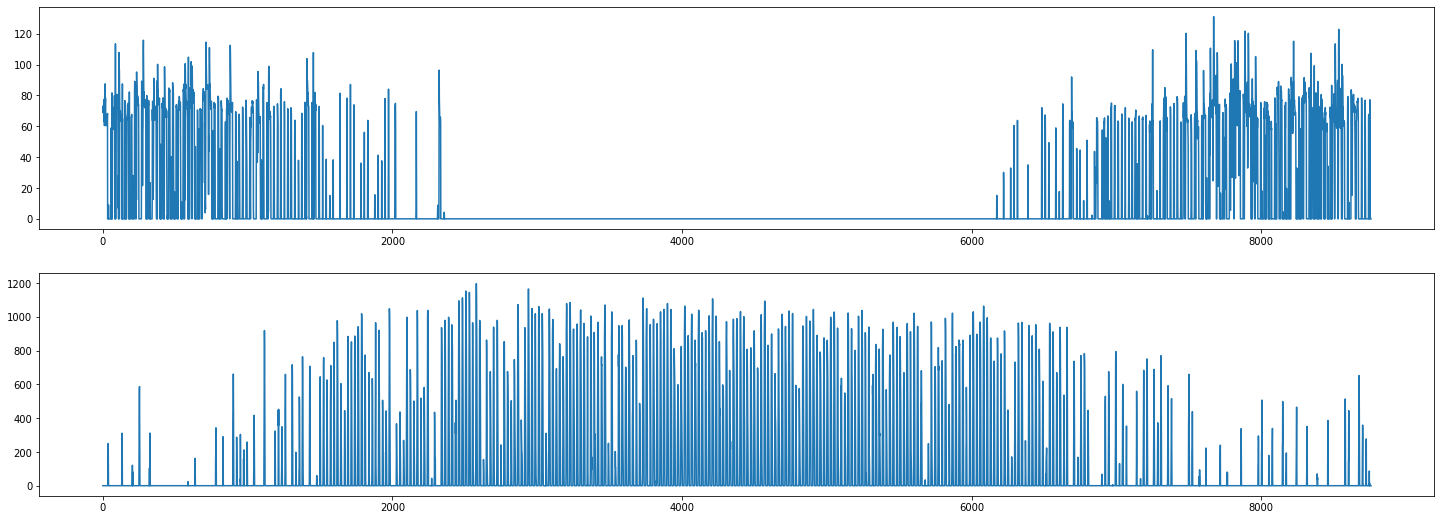

In [19]:
fig, ax = plt.subplots(2, figsize=[25,9])

ax[0].plot(_import_)
ax[1].plot(_export_)

In [14]:
importing = pd.DataFrame(_import_)
exporting = pd.DataFrame(_export_)
exporting.to_csv('Export_vector.csv')
importing.to_csv('Import_vector.csv')